# `pyprop8`

This notebook illustrates some of the functionality of [`pyprop8`](https://github.com/valentineap/pyprop8). For full details, take a look at [the documentation](https://pyprop8.readthedocs.io).

In [1]:
import numpy as np

import pyprop8 as pp
from pyprop8.utils import rtf2xyz, make_moment_tensor,stf_trapezoidal

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d


`pyprop8` is a pure-Python package that computes synthetic (simulated) seismic data in a 1D flat layered model. In order to calculate seismograms, we need to set up: (i) the earth model, (ii) some information about where the 'observations' are to be made, and (iii) a description of the seismic source.

### Set up the model
In `pyprop8`, the Earth is assumed to be a stack of (flat) layers, with the bottom layer extending to infinite depth. Each layer is described by its thickness, P- and S-wave velocities, and density; the last layer must have thickness `np.inf`.

In [2]:
#                                   Layer
#                                thickness Vp    Vs  Density
#                                    km   km/s  km/s  g/cm^3
model = pp.LayeredStructureModel([( 3.00, 1.80, 0.00, 1.02),
                                  ( 2.00, 4.50, 2.40, 2.57),
                                  ( 5.00, 5.80, 3.30, 2.63),
                                  (20.00, 6.50, 3.65, 2.85),
                                  (np.inf,8.00, 4.56, 3.34)]) 

# We can visualise the structure:
print(model)

------------------------------------------------------- z = 0.00 km
  vp = 1.80 km/s       FLUID        rho = 1.02 g/cm^3
------------------------------------------------------- z = 3.00 km
  vp = 4.50 km/s   vs = 2.40 km/s   rho = 2.57 g/cm^3
------------------------------------------------------- z = 5.00 km
  vp = 5.80 km/s   vs = 3.30 km/s   rho = 2.63 g/cm^3
------------------------------------------------------- z = 10.00 km
  vp = 6.50 km/s   vs = 3.65 km/s   rho = 2.85 g/cm^3
------------------------------------------------------- z = 30.00 km
  vp = 8.00 km/s   vs = 4.56 km/s   rho = 3.34 g/cm^3



### Set up the receivers
Next we need to define the coordinates of the seismic receivers, i.e. the locations for which we wish to compute synthetic seismograms.  For this example, we generate random locations; of course, it would be straightforward to reproduce the distribution of stations in a real deployment. Here, we are specifying locations relative to a Cartesian kilometre grid with arbitrary origin (i.e. location `(3,5)` is 2km east and 1km north of location `(1,4)`). It is also possible to specify locations using `(longitude, latitude)` coordinates (pass the option `geometry='spherical'` to `ListOfReceivers`) - but beware; the seismograms will still be calculated assuming a flat Earth.

In [3]:
nstations = 10
stations_xy = np.random.uniform(-50,50,size=[nstations,2])

receivers = pp.ListOfReceivers(*stations_xy.T,depth=3) 

### Set up the seismic source
Finally we can define the seismic source. `pyprop8` assumes a point source, which can be described by a moment tensor and/or a force vector. The source location is assumed to be given relative to the same coordinate system as was used for the receivers. The moment tensor needs to be expressed relative to a Cartesian coordinate system; the function `rtf2xyz` in `pyprop8.utils` can be used to convert moment tensors expressed in the spherical polar coordinate system that is used by (e.g.) the [Global CMT catalog](https://www.globalcmt.org). Also, `pyprop8.utils` provides a function `make_moment_tensor` that can be used to generate moment tensors from strike, dip and rake angles.

In [4]:
strike = 180
dip = 0
rake = 0
M0=1E7

mt_rtf = make_moment_tensor(strike, dip, rake, M0, 0, 0)
mt_xyz = rtf2xyz(mt_rtf)

point_force = np.zeros([3,1])

source_x = 10
source_y = -5
source_depth = 15

time = 0 # The time origin is arbitrary, so we assume that it coincides with the event time.

source = pp.PointSource(source_x,source_y,source_depth,mt_xyz,point_force,time)

We can also specify a source-time-function, by passing a callable function of frequency. A number of 'standard' options are available within `pyprop8.utils`.

In [5]:
source_time_func = lambda w: stf_trapezoidal(w, 3, 6)

To visualise the source-receiver geometry, we can plot a simple map.

Text(0, 0.5, 'South-North')

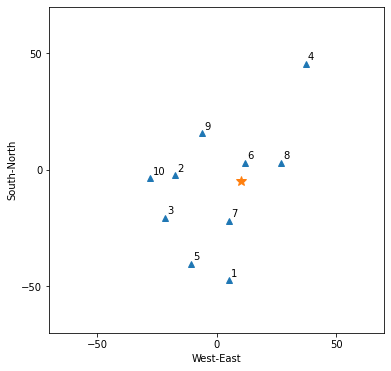

In [6]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(*stations_xy.T,marker='^',lw=0)
ax.plot([source.x],[source.y],marker='*',markersize=10)
for i in range(nstations):
    ax.text(stations_xy[i,0]+1,stations_xy[i,1]+1,"%i"%(i+1),verticalalignment='bottom',horizontalalignment='left')
ax.set_xlim(-70,70)
ax.set_ylim(-70,70)
ax.set_xticks([-50,0,50])
ax.set_yticks([-50,0,50])
ax.set_xlabel("West-East")
ax.set_ylabel("South-North")

## Seismograms!
Now we're ready to calculate some seimsograms! We set a sample spacing (i.e. the time interval, in seconds, between successive points in the seismogram) and fix the number of samples we wish to obtain. The first sample will correspond to `t=0`, and we set the event time to also be `t=0` (above).

In [7]:
nt = 80
delta_t = 0.5
time, seismograms = pp.compute_seismograms(model,source,receivers,nt,delta_t,source_time_function=source_time_func)

100%|███████████████████████████████████████████| 61/61 [00:01<00:00, 51.15it/s]


We can plot individual (3-component) seismograms:

Text(0.5, 0, 'Time (s)')

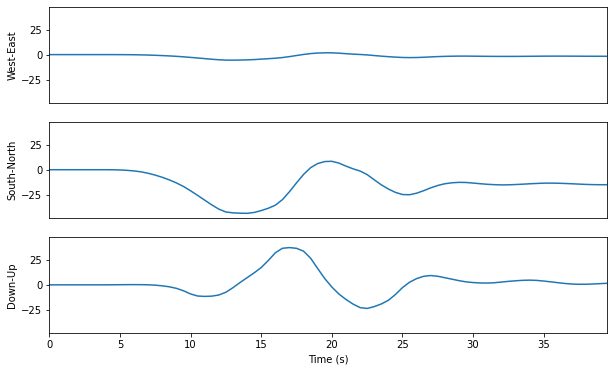

In [8]:
station_number = 1 # As given in the map above
irec = station_number - 1 # Because Python counts from 0

fig,ax = plt.subplots(3,figsize=(10,6))

#Plotting
ax[0].plot(time,seismograms[irec,0,:]) # x/West-East
ax[1].plot(time,seismograms[irec,1,:]) # y/South-North
ax[2].plot(time,seismograms[irec,2,:]) # z/Down-Up

# Add axis labels etc
[a.set_xticks([]) for a in ax[:-1]]
[a.set_xlim(0,(nt-1)*delta_t) for a in ax]
scale = abs(seismograms[irec,:,:]).max()*1.1
[a.set_ylim(-scale,scale) for a in ax]
ax[0].set_ylabel("West-East")
ax[1].set_ylabel("South-North")
ax[2].set_ylabel("Down-Up")
ax[-1].set_xlabel("Time (s)")

We can also make more complex figures, such as this visualisation of the particle motion:

Text(0.5, 0, 'Down-Up')

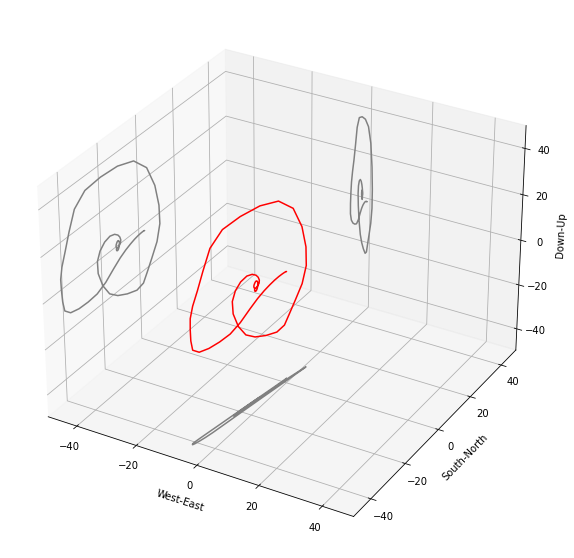

In [9]:
station_number = 1 # As given in the map above
irec = station_number - 1 # Because Python counts from 0

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

# Plot chosen seismogram in 3D
ax.plot3D(seismograms[irec,0,:],seismograms[irec,1,:],seismograms[irec,2,:],color='red')

# Plot 2D projections of particle motion on 'walls' of cube
ax.plot3D(seismograms[irec,0,:],np.full(nt,scale),seismograms[irec,2,:],color='grey')
ax.plot3D(np.full(nt,-scale),seismograms[irec,1,:],seismograms[irec,2,:],color='grey')
ax.plot3D(seismograms[irec,0,:],seismograms[irec,1,:],np.full(nt,-scale),color='grey')

#Add some labelling
ax.set_xlim(-scale,scale)
ax.set_xlabel("West-East")
ax.set_ylim(-scale,scale)
ax.set_ylabel("South-North")
ax.set_zlim(-scale,scale)
ax.set_zlabel("Down-Up")

## Static offset and InSAR

Depending on the source and receiver you have chosen, you may see that the particle motion is not a closed loop: when the ground shaking stops, some permanent deformation remains. This is the 'static offset', and for real earthquakes it can often be measured using (e.g.) [InSAR](https://en.wikipedia.org/wiki/Interferometric_synthetic-aperture_radar) or GPS receivers. 

One way to simulate this would simply be to calculate long seismograms and determine the final displacement. However, `pyprop8` also provides the facility to compute static deformation directly. Again, we must specify an earth model, a set of receivers/observation points, and the seismic source. We will reuse the model and source from earlier, but define observation points as a regular polar grid. (We could reuse our existing `receivers` object, but for this plot we want to characterise the displacement throughout our region.

In [10]:
receivers = pp.RegularlyDistributedReceivers(5,50,10,0,360,72,depth=3,x0=source.x,y0=source.y)

Plotting a map, we see this has created 6 concentric circles, each consisting of 36 receivers:

Text(0, 0.5, 'South-North')

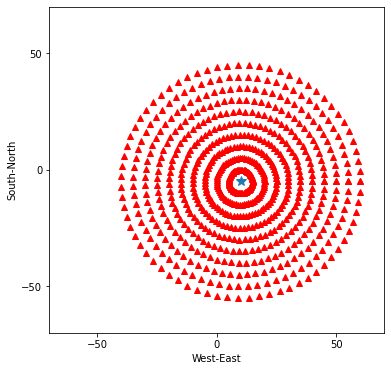

In [11]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(*receivers.as_xy(),marker='^',lw=0,color='r')
ax.plot([source.x],[source.y],marker='*',markersize=10)
ax.set_xlim(-70,70)
ax.set_ylim(-70,70)
ax.set_xticks([-50,0,50])
ax.set_yticks([-50,0,50])
ax.set_xlabel("West-East")
ax.set_ylabel("South-North")

For observation techniques such as InSAR, we only have data about the component of deformation along the line-of-site of a satellite. We therefore need to define the direction(s) in which we are making measurements.

In [12]:
satellite_elevation = 30
satellite_azimuth = 0

elev = np.deg2rad(satellite_elevation)
azim = np.deg2rad(satellite_azimuth)
line_of_sight = np.array([np.sin(90-elev)*np.cos(azim),np.sin(90-elev)*np.sin(azim),np.cos(90-elev)])

Now we can calculate the component of static deformation in this direction.

In [13]:
static = pp.compute_static(model,source,receivers,los_vector=line_of_sight)

We can use `contourf` to plot this:

Text(0, 0.5, 'South-North')

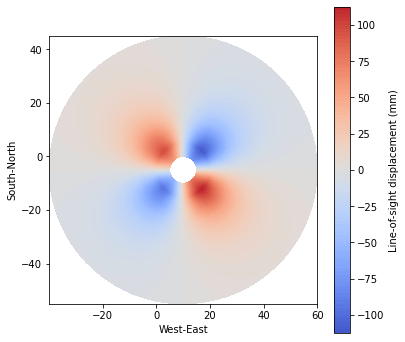

In [14]:
fig,ax = plt.subplots(1,figsize=(6,6))

cmax = abs(static).max()*1.05
c = ax.contourf(*receivers.as_xy(),static,100,cmap=plt.cm.coolwarm)
c.set_clim(-cmax,cmax)
plt.colorbar(c,label="Line-of-sight displacement (mm)")
ax.set_aspect(1.)
ax.set_xlabel("West-East")
ax.set_ylabel("South-North")

To simulate an interferogram, we just need to use the `%` operator to calculate the remainder upon division by the fringe spacing.

Text(0, 0.5, 'South-North')

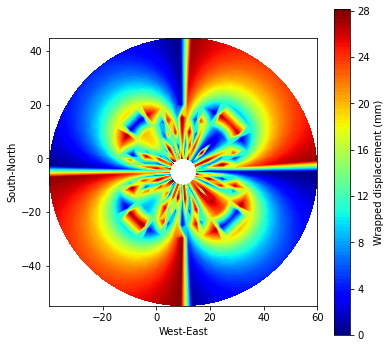

In [15]:
fringes = 28
fig,ax = plt.subplots(1,figsize=(6,6))


c = ax.contourf(*receivers.as_xy(),static%fringes,100,cmap=plt.cm.jet)
cmax = fringes # Colour maximum
c.set_clim(0,cmax)
plt.colorbar(c,ax=ax,ticks=np.arange(0,29,4),label="Wrapped displacement (mm)")
ax.set_aspect(1.)
ax.set_xlabel("West-East")
ax.set_ylabel("South-North")

We can make this look better by interpolating onto a denser (Cartesian) grid.

Text(0, 0.5, 'South-North')

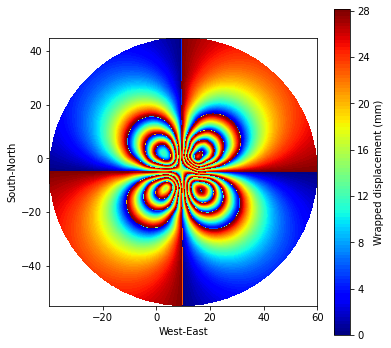

In [17]:
xx, yy = receivers.as_xy() # x/y coordindates of our calculation points

# Use matplotlib's triangulation routines
from matplotlib.tri import Triangulation, CubicTriInterpolator
tri = Triangulation(xx.flatten(),yy.flatten()) # Set up triangulation
f = CubicTriInterpolator(tri,static.flatten()) # Interpolator function

grid_x, grid_y = np.meshgrid(np.linspace(xx.min(),xx.max(),500),np.linspace(yy.min(),yy.max(),500))
grid_z = f(grid_x,grid_y)%fringes

fig,ax = plt.subplots(1,figsize=(6,6))
c = ax.contourf(grid_x,grid_y,grid_z ,100,cmap=plt.cm.jet)
cmax = fringes # Colour maximum
c.set_clim(0,cmax)
plt.colorbar(c,ax=ax,ticks=np.arange(0,29,4),label="Wrapped displacement (mm)")
ax.set_aspect(1.)
ax.set_xlabel("West-East")
ax.set_ylabel("South-North")